In [1]:
# attempt to see how mnay galaxies do we need to get to get the error we want (using subset approach for errors)

In [100]:
import os
os.environ["JAX_ENABLE_X64"] = "True"


In [101]:
from tqdm import tqdm 

In [102]:
from functools import partial

import bpd

from jax import jit, vmap

import jax.numpy as jnp

from bpd.sample import sample_noisy_ellipticities_unclipped
from bpd.pipelines import logtarget_toy_ellips, pipeline_shear_inference_simple

from bpd.chains import run_inference_nuts

from jax import random

import matplotlib.pyplot as plt 

import numpy as np 


In [103]:
seed = 99
g1 = 0.02
g2 = 0.0

shape_noise = 0.2
sigma_e_int=0.3
sigma_m = 0.01

In [104]:
# sample ellipticities

k = random.key(seed)
k1, k2, k3, k4 = random.split(k, 4 )
true_g = jnp.array([g1, g2])

In [107]:
e_obs_p, _, e_int = sample_noisy_ellipticities_unclipped(
    k1, g=true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=100_000
)

e_obs_m, _, _ = sample_noisy_ellipticities_unclipped(
    k1, g=(-1) * true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=100_000
)

In [108]:
e_obs_p.shape, e_obs_m.shape

((100000, 2), (100000, 2))

In [76]:
def get_e1e2_post(key, e_obs_plus, e_obs_minus, *, sigma_e_int, sigma_m, n_samples=300):

    _logtarget = partial(logtarget_toy_ellips, sigma_m=sigma_m, sigma_e_int=sigma_e_int)

    k2s = random.split(key, e_obs_plus.shape[0])

    _pipe = jit(
        partial(
            run_inference_nuts,
            logtarget=_logtarget,
            n_samples=n_samples,
            initial_step_size=0.01,
            max_num_doublings=2,
            n_warmup_steps=500,
        )
    )
    pipe = vmap(_pipe, in_axes=(0, 0, 0))

    _ = pipe(k2s[:2], e_obs_plus[:2], e_int[:2])
    
    e1e2p = pipe(k2s, e_obs_plus, e_int)
    e1e2m = pipe(k2s, e_obs_minus, e_int)

    return e1e2p, e1e2m

In [115]:
# now  obtain posteriors 
e1e2p, e1e2m = get_e1e2_post(k2, e_obs_p, e_obs_m, sigma_e_int=sigma_e_int, sigma_m=sigma_m, n_samples=500)

In [116]:
e1e2p.shape, e1e2m.shape

((100000, 500, 2), (100000, 500, 2))

In [117]:
def get_shear(key, e1e2, *, shape_noise, sigma_e_int, n_samples:int=1000):
    
    raw_pipeline = partial(
        pipeline_shear_inference_simple,
        init_g=jnp.array([0.0, 0.0]),
        sigma_e=shape_noise ,
        sigma_e_int=sigma_e_int,
        n_samples=n_samples,
        initial_step_size=0.01,
    )
    pipe = jit(raw_pipeline)


    return pipe(key, e1e2)

In [118]:
gp = get_shear(k3, e1e2p, shape_noise=shape_noise , sigma_e_int=sigma_e_int)
gp.shape

(1000, 2)

In [139]:
gp[:, 0].mean(), gm[:, 0].mean(), gp[:, 0].std()

(Array(0.02003458, dtype=float64),
 Array(-0.01808311, dtype=float64),
 Array(0.0006277, dtype=float64))

In [119]:
gm = get_shear(k3, e1e2m, shape_noise=shape_noise , sigma_e_int=sigma_e_int)
gm.shape

(1000, 2)

In [120]:
m = (gp[:, 0].mean() - gm[:, 0].mean()) / 2/ 0.02 -1
m

Array(1.98716683e-05, dtype=float64)

## Subset errors

In [123]:
n_subsets = 500 
n_samples = 500
k3s = random.split(k3, n_subsets)

In [124]:
e1e2ps = e1e2p.reshape(n_subsets, -1, n_samples, 2)
e1e2ms = e1e2m.reshape(n_subsets, -1, n_samples, 2)
e1e2ps.shape

(500, 200, 500, 2)

In [125]:
pipe = jit(partial(get_shear, shape_noise=shape_noise, sigma_e_int=sigma_e_int))

In [126]:
gps = vmap(pipe)(k3s, e1e2ps)

In [127]:
gms = vmap(pipe)(k3s, e1e2ms)

In [128]:
gps.shape, gms.shape

((500, 1000, 2), (500, 1000, 2))

In [129]:
ms = (gps[...,0].mean(1) - gms[...,0].mean(1)) / 2/ 0.02 - 1
ms.shape

(500,)

(array([  6.,  19.,  42.,  88., 132., 106.,  66.,  31.,   8.,   2.]),
 array([-0.0358524 , -0.02837767, -0.02090294, -0.01342821, -0.00595349,
         0.00152124,  0.00899597,  0.0164707 ,  0.02394543,  0.03142016,
         0.03889488]),
 <BarContainer object of 10 artists>)

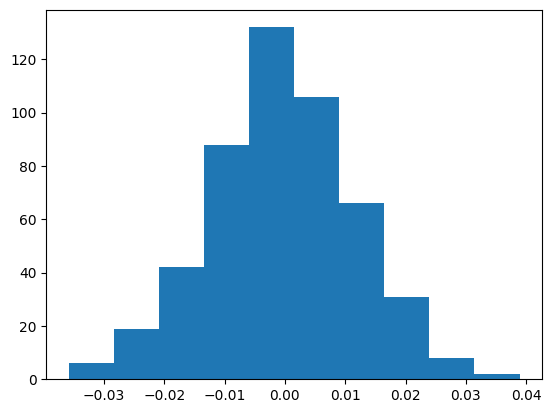

In [130]:
plt.hist(ms)

In [131]:
ms.mean(), ms.std() / np.sqrt(len(ms))

(Array(-0.00049451, dtype=float64), Array(0.000536, dtype=float64))

In [132]:
ms.std() / np.sqrt(len(ms)) * 3

Array(0.001608, dtype=float64)

In [133]:
m

Array(1.98716683e-05, dtype=float64)